*The codes were developed on Windows 10, and were not tested on other machines. Anaconda 5.2.0 is chosen as a Python interpreter.*

This notebook introduces the concept and methodology of implementing Bootstrap Simulation.

# Bootstrap Simulation

> **Bootstrap Simulation** is a non-parametric statistical technique to resample from known samples to estimate uncertainty in summary statistics. When there are small, limited number of samples, it gives a more accurate forecast model than directly obtaining a forecast model from the limited sample pool. It is non-parametric because it does not require any prior knowledge of the distribution (shape, mean, standard devation, etc..).

One goal of inferential statistics is to determine the value of a parameter of an entire population. It is typically too expensive or even impossible to measure this directly. So we use statistical sampling. We sample a population, measure a statistic of this sample, and then use this statistic to say something about the corresponding parameter of the population.

Bootstrapping is a type of resampling method to save time and money taking measurements. It picks a random value from a sample pool N times **with replacement**, and create M number of new Bootstrapped-sample pools. The term **with replacement** here means that you put back the sample you drew to the original sample pool after adding it to a new Bootstrapped-sample pool. Thick of it this way: you randomly choose a file from a folder in your PC, and you *copy* and paste the randomly-chosen file into a new folder. You do not *cut* and paste the file, but you *copy* and paste file into a new folder. You will have M number of folders, each containing N number of files.

Bootstrapping is used for three reasons:

1. Bootstrap can obtain confidence interval in any statistics.
2. Bootstrap does not assume anything about a distribution.
3. Bootstrap helps when there are to few number of samples.

** imports **

In [223]:
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Confidence Interval in Population Parameters: US Male Height Example

Bootstrap simulation can be run to obtain confidence intervals in various population parameters: mean, stdev, variance, min, or max. In this example, we will assume a scenario in which we know the distribution of a population. Bootstrap simulations can give us something like the following:

<div class="alert alert-info">
    <p>By 95% chance, the following statistics will fall within the range of:</p>
    <br><b>Mean : </b>75.2 ~ 86.2, with 80.0 being the average
    <br><b>Standard Deviation : </b>2.3 ~ 3.4 with 2.9 being the average
    <br><b>Min : </b>54.3 ~ 57.2, with 55.2 being the average
    <br><b>Max : </b>77.8 ~ 82.4, with 79.8 being the average
    <br><b>Skew : </b>-0.053 ~ 0.323, with 0.023 being the average</p>    
</div>

### 1.1 Initial Data From the US Census Bureau

From the U.S. Census Bureau, you obtained the mean and standard deviation values for the US males and females height. The distribution is Gaussian, and the statistics are as follows:

In [282]:
census_data = pd.DataFrame(data=[[69.7], [2.9]], columns=['Male Height (inches)'], index=['mean', 'stdev'])
census_data

,Male Height (inches)
mean,69.7
stdev,2.9


### 1.2 Random Sampling Through Monte-Carlo Simulation 

Based on the mean and standard deviation values of the Gaussian weight distribution, [Monte-Carlo Simulation](https://nbviewer.jupyter.org/github/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/Uncertainty%20Modeling%20with%20Monte-Carlo%20Simulation.ipynb) can be run to generate random samples. 

<div class="alert alert-info">
    <h4>Notes:</h4> 
    <p>In this scenario, <b>Monte-Carlo simulation</b> is used to perform random sampling, because we have only the mean and standard deviation values of the population. Currently there are no samples. Since <b>Bootstrap random sampling</b> is resampling from a sample pool, without the existence of a sample pool, Bootstrap random sampling can't be done.</p>
</div>

** Simulate Random Samples **

Monte-Carlo simulation will be repeated 1000 times to obtain 1000 random samples.

In [284]:
monte_iter = 1000
male       = np.random.normal(census_data['Male Height (inches)']['mean'], census_data['Male Height (inches)']['stdev'], monte_iter)
monte_data = pd.DataFrame([male], index=['Male Height (inches)']).T

** Visualize **

In [285]:
def visualize_gaussian(dataframe, ax_):
    labels = list(map(lambda x: re.sub(" \(.*?\)", "", x), dataframe.columns))
    dataframe = dataframe.apply(lambda x: x.sort_values().values)

    for col, label in zip(dataframe, labels):
        fit = stats.norm.pdf(dataframe[col], np.mean(dataframe[col]), np.std(dataframe[col]))
        ax_.plot(dataframe[col], fit, label=label,)
    ax_.legend()
    ax_.set_ylabel('Probability')
    return ax_

<IPython.core.display.Javascript object>


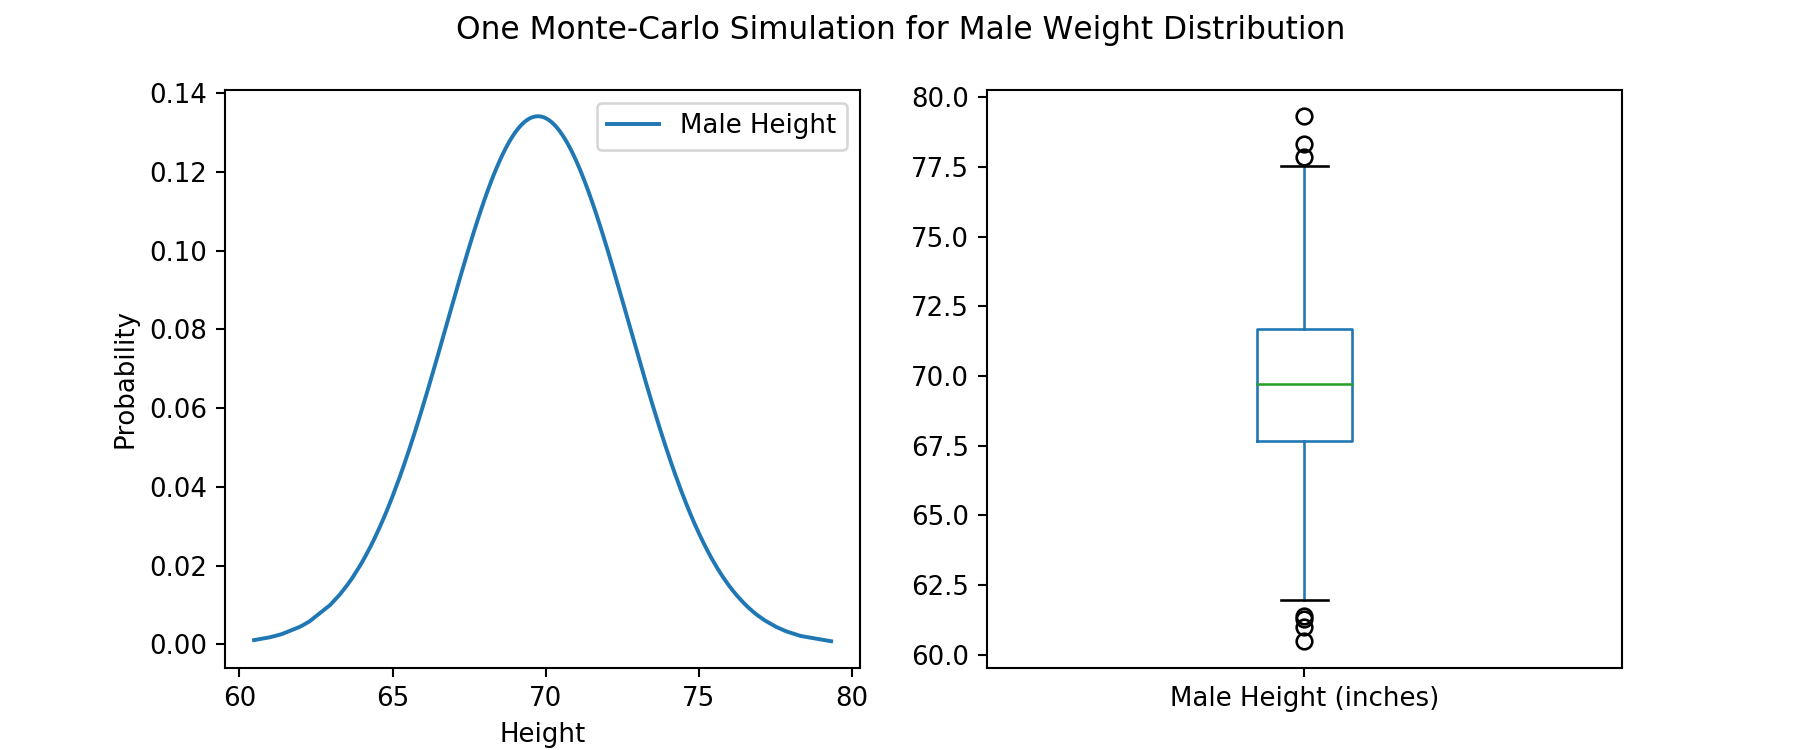

In [322]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('One Monte-Carlo Simulation for Male Weight Distribution')

visualize_gaussian(monte_data, ax1)
ax1.set_xlabel('Height')

monte_data.boxplot(ax=ax2, grid=False);

<div class="alert alert-info">
    <p>Based on the boxplot generated, <b>half</b> of the US male height falls within the range of 67.5 ~ 72.5 inches (5ft 7.5 inches ~ 6 ft), and <b>most</b> of the US male height falls within the range of 62.0 ~ 77.5 inches (5ft 2 inches ~ 6ft 5.5 inches)</p>
</div>

We have now obtained the uncertainty in the heights. In the other words, we obtained the uncertainty in **values** of heights. What if we want to further investigate the distribution, and obtain uncertainty in summary statistics (mean, std, skew, kurtosis, min, max, etc...)? Bootstrap simulation can address our need.

### 1.2 Bootstrapping with 100 Monte-Carlo Simulations

In this scenario, Bootstrap simulation will be run 100 times. It can be done by running 100 Monte-Carlo simulations. In Bootstrap, each simulation is called a *realization*. Each Bootstrap realization is 1 x N Monte-Carlo array, where N is 1000, as it was defined above.

** Bootstrap Simulation **

In [327]:
bootstrap_iter = 100
monte_iter = 1000

# monte_data = pd.DataFrame([male, female], index=['Male (inches)', 'Female (inches)']).T

realizations_male = []
realizations_female = []
for i in range(bootstrap_iter):
    male = np.random.normal(census_data['Male Height (inches)']['mean'], census_data['Male Height (inches)']['stdev'], monte_iter) 
    realizations_male.append(male)

** Male Weight Boostrap Realizations Table **

In [328]:
columns = ['Realization ' + str(i + 1) for i in range(bootstrap_iter)]
index = [str(i + 1) for i in range(monte_iter)]
df_male = pd.DataFrame(realizations_male, index=columns, columns=index)
df_male.index.name = 'Monte-Carlo Iteration'
df_male.round(1).T.iloc[[0, 1, 2, 997, 998, 999], [0, 1, 2, 3, 96, 97, 98, 99]]                                  

Monte-Carlo Iteration,Realization 1,Realization 2,Realization 3,Realization 4,Realization 97,Realization 98,Realization 99,Realization 100
1,68.3,71.6,67.6,68.0,66.8,67.3,71.1,69.0
2,73.0,70.4,67.4,67.2,69.4,72.2,69.5,65.4
3,69.8,70.4,70.0,71.6,72.7,72.0,71.4,70.3
998,64.2,69.5,69.9,68.0,71.0,70.0,72.0,66.9
999,69.8,68.7,69.2,70.6,73.7,65.7,69.3,70.3
1000,66.0,65.3,70.9,69.6,75.3,75.0,67.4,72.6


### 1.3 Bootstrapped Population Parameters

After the Bootstrap simulation, we now have 100 Bootstrap-population pools (realizations). Summary statistics can be generated for each Bootstrap-population. Each summary statistics will have 100 values, since there are 100 population pools. Observe how any kind of summary statistics can be obtained using the Bootstrap-simulated data.

In [329]:
df_male.index.name = ''
df_male_summary = df_male.T.describe().T[['mean', 'std', 'min', 'max']]
df_male_summary['variance'] = df_male.T.var()
df_male_summary['skew'] = df_male.T.skew()
df_male_summary['kurtosis'] = df_male.T.kurtosis()

df_male_summary.round(1).T.iloc[:, [0, 1, 2, 3, 96, 97, 98, 99]]

,Realization 1,Realization 2,Realization 3,Realization 4,Realization 97,Realization 98,Realization 99,Realization 100
mean,69.7,69.7,69.7,69.7,69.6,69.8,69.9,69.7
std,3.0,2.9,3.1,2.9,2.9,2.9,2.8,2.8
min,60.3,60.5,60.0,57.6,59.8,60.7,61.0,61.2
max,80.9,77.6,79.7,79.9,78.9,79.4,78.6,79.9
variance,8.8,8.3,9.5,8.3,8.3,8.4,7.9,7.9
skew,0.1,-0.1,-0.1,0.0,-0.0,0.0,0.1,-0.1
kurtosis,0.3,0.1,0.0,0.5,-0.0,-0.0,-0.1,-0.1


** Uncertainty Modeling with Boxplots **

<IPython.core.display.Javascript object>


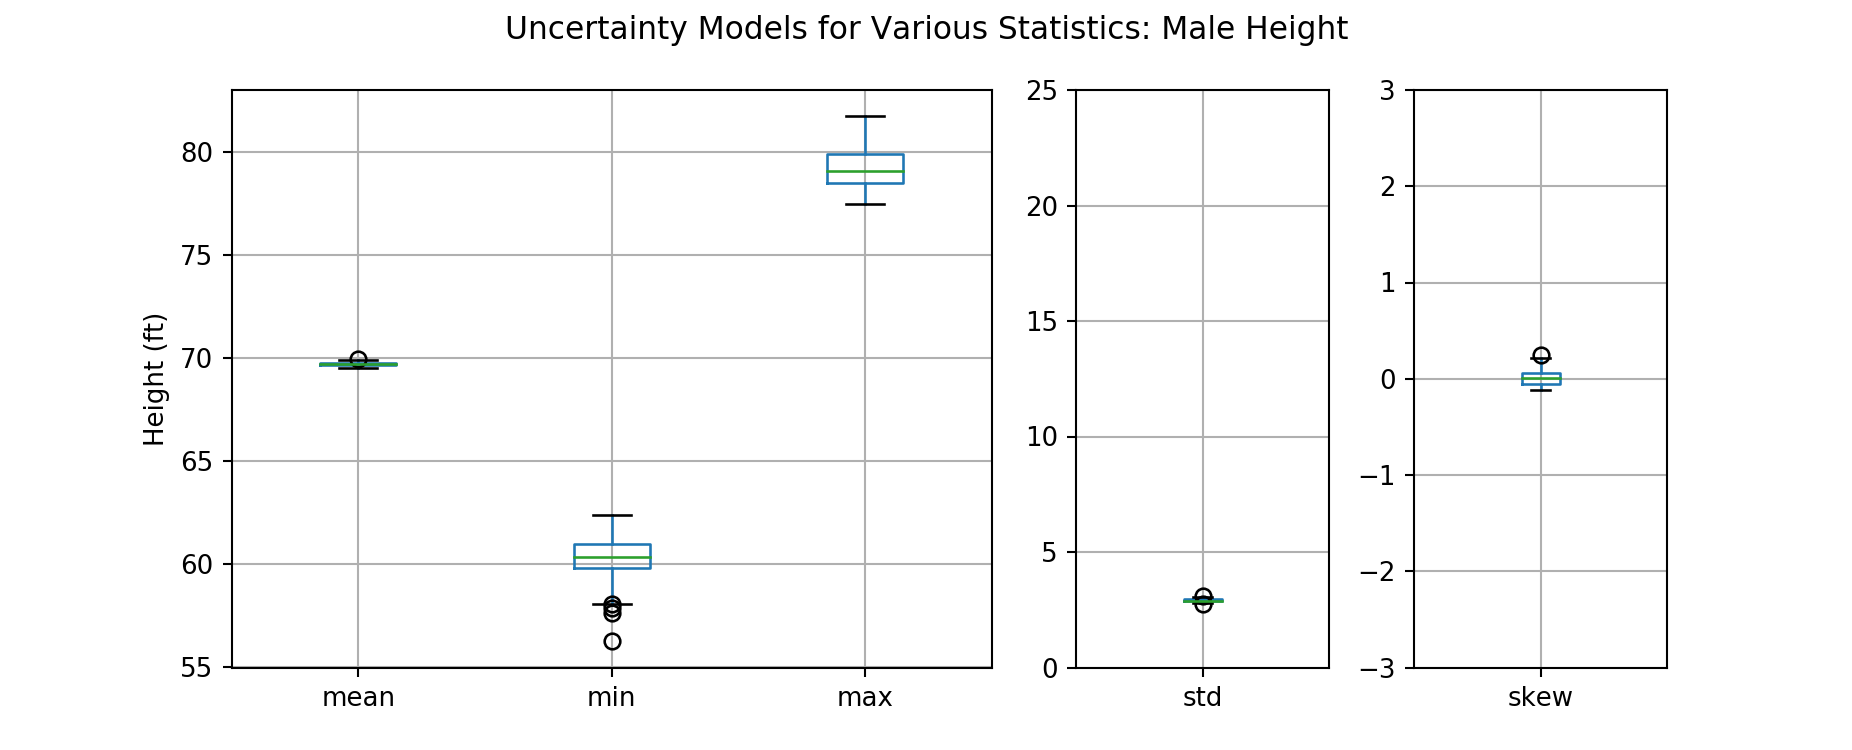

In [330]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw = {'width_ratios':[3, 1, 1]})
fig.suptitle('Uncertainty Models for Various Statistics: Male Height')

df_male_summary[['mean', 'min', 'max']].boxplot(ax=ax1)
pd.DataFrame(df_male_summary['std']).boxplot(ax=ax2)
pd.DataFrame(df_male_summary['skew']).boxplot(ax=ax3)

ax1.set_ylabel('Height (ft)')
ax2.set_ylim([0, 25])
ax3.set_ylim([-3, 3]);

<div class="alert alert-info">
    <h4>Notes:</h4> 
    <p>There are negligible uncertainties in the summary statistics because the random samples were drawn from a perfect Gaussian distribution.</p>
</div>

** Confidence Intervals of Population Parameters **

In [312]:
conf_int = df_male_summary.describe(percentiles=[0.1, 0.5, 0.9]).iloc[4:7, :].T
conf_int.columns = ['P10', 'P50', 'P90']
conf_int.round(1)

,P10,P50,P90
mean,69.6,69.7,69.8
std,2.8,2.9,3.0
min,59.2,60.7,61.6
max,78.0,78.9,80.4
variance,7.9,8.4,8.8
skew,-0.1,0.0,0.1
kurtosis,-0.2,-0.0,0.1


Based on the **P10, P50, P90**

<p><center><b>Bootstrap can obtain confidence interval in any statistics</b></center></p>

It can provide confidence interval in virtually any statistical values (mean, standard deviation, skewness, kurtosis, etc..), when the formula to calculate them is unknown. Let's assume that you want to obtain an uncertainty model for the weights of 5th-grade students in a region. If you know the weight distribution of the students from some type of a government statistic report, you can implement *Monte-Carlo Simulation* to generate virtually unlimited number of random samples. This one Monte-Carlo simulation contains N number of random samples, and summary statistics can be drawn from this data. Mean, standard deviation, min, max, P10, or P90 values can be obtained. However, how sure do you feel about these summary statistics? What is the uncertainty in these values? 

For example, from a single Monte-Carlo simulation, you found out that the mean ($\mu$) weight of the US 5th-grade boys is 80 lbs. How can you obtain the uncertainty in the mean weight of the students? The answer is simple: you perform Monte-Carlo simulation hundreds of times, and obtain hundreds of mean values. Since there is a large enough number of mean values, reliable P10 and P90 values can be obtained to draw an uncertainty model for the mean weight of the students. You will end up with something like $\mu$ = 80 $\pm$ 3 lbs.

What if you want to get an uncertainty model for the standard deviation ($\sigma$) of the weight of the students? It's the same: you performn Monte-Carlo simulation hundreds of times, and obtain hundreds of standard deviation values. Then obtain P10 and P90 values of your collection of standard deviations, and draw an uncertainty model for it. You will end up with something like $\sigma$ = 6 $\pm$ 1.3 lbs.

<p><center><b>Bootstrap does not assume anything about the distribution of a population</b></center></p>

Bootstrapping is tied to Monte-Carlo simulation in a sense that it is similar to performing Monte-Carlo simulation many times (recall that Monte-Carlo simulation is performing *random sampling* many times). However, Monte-Carlo simulation requires knowledge about the distribution shape, mean, and standard deviation of the population to generate random samples. What if you do not have any knowledge of those values? 

Bootstrapping is a type of a *resampling* method. You pick a random value from a sample pool N times **with replacement**, and create M number of new Bootstrapped-sample pools. The term **with replacement** here means that you put back the sample you drew to the original sample pool after adding it to a new Bootstrapped-sample pool. Thick of it this way: you randomly choose a file from a folder in your PC, and you *copy* and paste the randomly-chosen file into a new directly. You do not *cut* and paste the file, but you *copy* and paste file. You will end up with N x M matrix of samples, where M is the number of Bootstrap sample pools, and N is the number of random samples in a Bootstrap sample pool.

Because all Bootstrapping is doing is just *resampling* the data by choosing random values from a sample pool, it does not assume anything about the distribution. You do not know to know the distribution parameters of the population to generate random samples.

<p><center><b>Bootstrap can be helpful when there are too few samples</b></center></p>

Ideally, you would want to draw large, non-repeated, samples from a population in order to create a sampling distribution for a statistic. However, you may be limited to one sample because of finances or time. This single sample method can serve as a mini population, from which repeated small samples are drawn with replacement over and over again. As well as saving time and money, bootstrapped samples can be quite good approximations for population parameters.


In [ ]:
census_data = pd.DataFrame(data=[[69.7, 64.3], [2.9, 2.6]], columns=['Male (inches)', 'Female (inches)'], index=['mean', 'stdev'])
census_data